In [1]:
import numpy as np 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2

# Model Construction

In [3]:
from torchvision.models.optical_flow import raft_small, Raft_Small_Weights
from torchvision.utils import flow_to_image
from torchvision import transforms

weights = Raft_Small_Weights.DEFAULT
flow_model = raft_small(weights=Raft_Small_Weights.DEFAULT, progress=False)
flow_model = flow_model.eval()
flow_tf = weights.transforms()

Downloading: "https://download.pytorch.org/models/raft_small_C_T_V2-01064c6d.pth" to /root/.cache/torch/hub/checkpoints/raft_small_C_T_V2-01064c6d.pth


# Test

In [4]:
from models.common import *
from models.CAE_ConvLSTM import *
me = MotionEncoder()
cae = CAE(nf = 22, in_chan = 11)
checkpoint = torch.load('/kaggle/input/checkpoints/checkpoint_cvae_302.pt', map_location='cpu')
me.load_state_dict(checkpoint['me'])
cae.load_state_dict(checkpoint['cvae'])
import gc
gc.collect()

18

In [5]:
def inference(inputs):
    preds = []
    for i in range(1):
        flow_array = []
        for j in range(4):
            b1 = inputs[:,j]
            b2 = inputs[:,j+1]
            b1, b2 = flow_tf(b1, b2)
            flow = torch.stack(flow_model(b1, b2))
            flow = flow[-1][0].unsqueeze(0)
            flow_array.append(flow.detach().numpy())
        flow = torch.from_numpy(np.average(np.array(flow_array), axis=0))
        flow = F.upsample(flow, size=(128,128), mode='bilinear', align_corners=True)
        z, logvar = me(flow)

        # stack
        z_matched = z.view(z.size(0), z.size(1), 1, 1).expand(inputs.size(0), inputs.size(1), z.size(1), inputs[0].size(2), inputs[0].size(3))      
        inputs = torch.cat((inputs, z_matched), 2)

        # inference
        x = cae(inputs).permute(0, 2, 1, 3, 4).detach()
        for i in range(1):
            preds.extend(x.detach().cpu().numpy().squeeze())
    
    pred = np.average(preds, axis=0)
    return pred, preds


In [6]:
def video_processor(input_file):
    vidcap = cv2.VideoCapture(input_file)
    success,image = vidcap.read()
    count = 0
    frames = []
    while success:
        success, image = vidcap.read()
        count += 1
        if image is not None:
            frames.append(image[:,:,::-1])

            
    train_seq = np.array(frames[0:25:5])
    gt = np.average(np.array(frames[0:100:5]), axis=0)
    return torch.from_numpy(train_seq).unsqueeze(0).permute(0, 1, 4, 2, 3), np.uint8(gt)

In [7]:
def restore_aspect_ratio(pred, size):
    return F.interpolate(torch.from_numpy(pred).unsqueeze(0), size=size).detach().numpy().squeeze().transpose(1,2,0)
    

In [13]:
in_seq, gt = video_processor('/kaggle/input/demolivedataset/pexels-antoni-shkraba-8064146-1440x1800-30fps.mp4')
print(in_seq.shape) # should be [b, 5, 3, 360, 640]
orig_size = in_seq.shape[3:]
in_seq_s = torch.nn.functional.interpolate(in_seq, size=(3, 360, 640))/255.0
print(in_seq_s.shape)

torch.Size([1, 5, 3, 1800, 1440])
torch.Size([1, 5, 3, 360, 640])


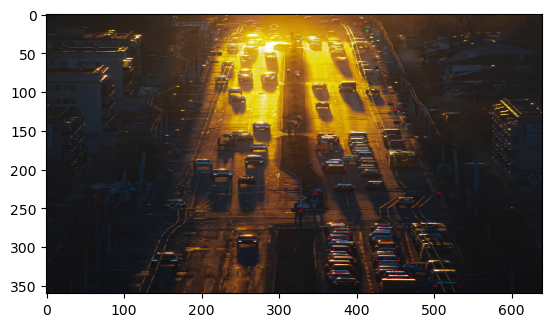

In [14]:
plt.imshow(in_seq_s[0][0].permute(1,2,0))

In [15]:
pred, preds = inference(in_seq_s)

Text(0.5, 1.0, 'Average of Train Seq')

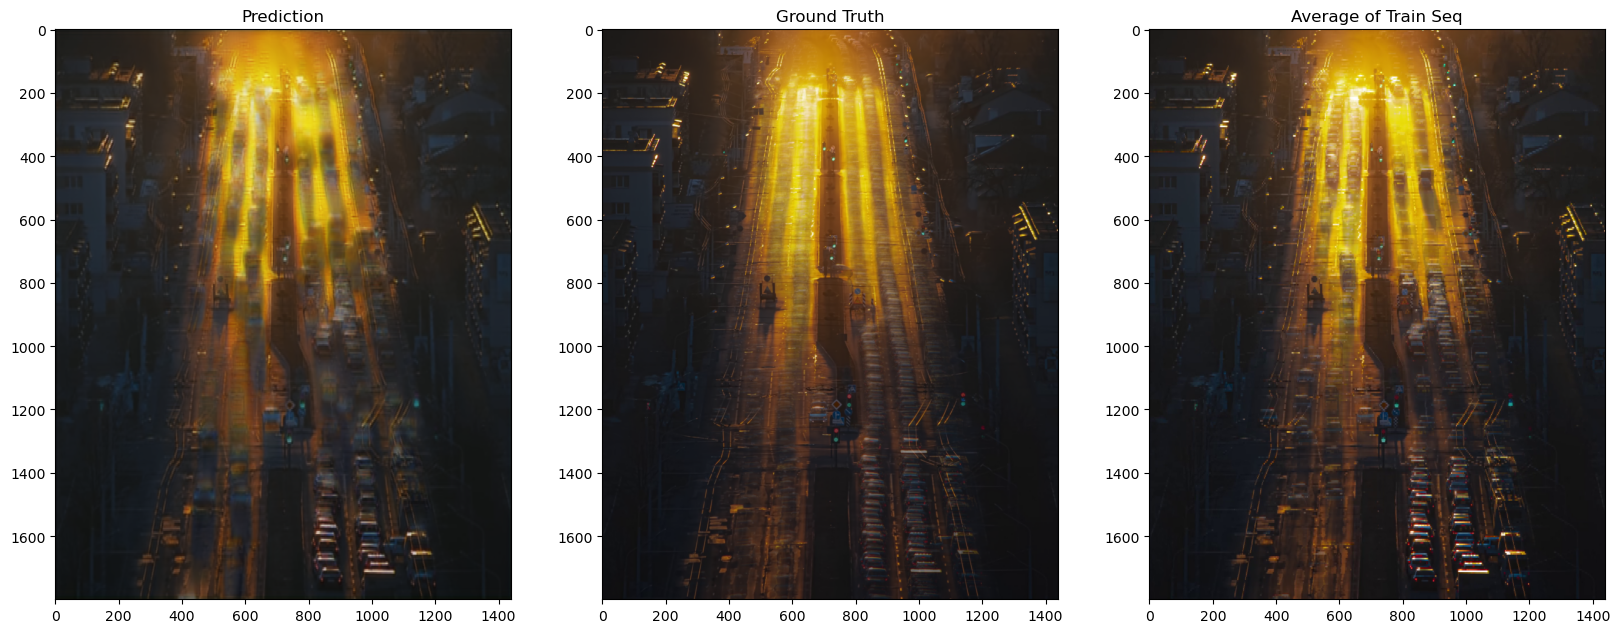

In [16]:
f, axarr = plt.subplots(1,3, figsize=(20,12))

axarr[0].imshow(restore_aspect_ratio(pred, orig_size))
axarr[0].set_title('Prediction')
axarr[1].imshow(gt)
axarr[1].set_title('Ground Truth')
axarr[2].imshow(restore_aspect_ratio(np.average(in_seq_s[0], axis=0), orig_size))
axarr[2].set_title('Average of Train Seq')
